# TF-IDF Example from scikit-learn docs

Adapted from:

https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

In [1]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


In [2]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [3]:
CPA = pd.read_csv("../data/processed/CPA_tokenized.csv")
CPA.drop('Unnamed: 0', axis=1, inplace=True)
CPA.head()

,Order,Level,Code,Parent,Descr,tokens
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",PRODUCTS OF AGRICULTURE FORESTRY AND FISHING
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services
2,1208794,3,01.1,01,Non-perennial crops,Non-perennial crops
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds",Cereals leguminous crops oil seeds
4,1208796,5,01.11.1,01.11,Wheat,Wheat


In [4]:
# Create categories for Level 1 and Level 2 higherarchies
CPA2 = CPA.copy()
#get highest level of code
CPA2.loc[CPA2.Level !=1,'Category_2'] = CPA2[CPA2.Level !=1].Code.str.split('.').str.slice(0,1).str.join('')

# match up codes and parents
Code_parent = CPA2[CPA2.Level==2][['Parent','Category_2']].copy()
CPA2 = CPA2.merge(Code_parent.rename(columns={'Parent':'Category_1'}), on='Category_2', how='left')

# add in the Category_1 fileds for Level1
CPA2.loc[CPA2.Level==1, 'Category_1'] = CPA2.loc[CPA2.Level==1,'Code']

# we now set up a higher level for A10 indstry levels (10 categories)
update_dict0 = {'A':1,'F':3,'J':5, 'K':6, 'L':7,'M':8,'N':8}
update_dict = {**update_dict0,**dict.fromkeys(['B','C','D','E'],2),**dict.fromkeys(['G','H','I'],4),
               **dict.fromkeys(['O','P','Q'],9), **dict.fromkeys(['R','S','T','U'],10)}

CPA2['Category_0'] = CPA2.Category_1.replace(update_dict)
#CPA2 = CPA2.astype({'Category_0':int})
CPA2.head()

2020-11-19 10:27:46,286 INFO NumExpr defaulting to 4 threads.


,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",PRODUCTS OF AGRICULTURE FORESTRY AND FISHING,NaN,A,1
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services,01,A,1
2,1208794,3,01.1,01,Non-perennial crops,Non-perennial crops,01,A,1
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds",Cereals leguminous crops oil seeds,01,A,1
4,1208796,5,01.11.1,01.11,Wheat,Wheat,01,A,1


In [5]:
# We now create an example based on Level 6 data
CPA_L6 = CPA2[CPA2.Level==6]
CPA_L6.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1


## Notes on using TFIDF
CountVectorizer implements both tokenization and occurrence counting in a single class

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model

See also [scikit-learn on clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [6]:
# now reapeat using the ngram character vectorizer
char_ngram_vectorizer = CountVectorizer(analyzer='char', ngram_range=(5, 5))
X3 = char_ngram_vectorizer.fit_transform(CPA_L6.tokens)

In [7]:
%pprint

Pretty printing has been turned OFF


In [8]:
char_ngram_vectorizer.get_feature_names()[160:240]

[' bags', ' bake', ' baki', ' bala', ' bale', ' ball', ' bals', ' bamb', ' band', ' bank', ' barb', ' baro', ' bars', ' base', ' basi', ' bask', ' bast', ' bath', ' batt', ' bayo', ' beac', ' bead', ' beam', ' bean', ' bear', ' beau', ' bed ', ' bedr', ' beds', ' bee-', ' beer', ' beet', ' bein', ' belt', ' bend', ' bene', ' bent', ' berr', ' bert', ' beta', ' bett', ' beve', ' bib ', ' bicy', ' bide', ' bifu', ' bill', ' bind', ' bing', ' bino', ' bioh', ' biol', ' biot', ' bird', ' bisc', ' bitu', ' blac', ' blad', ' blan', ' blas', ' blaz', ' blin', ' bloc', ' bloo', ' blou', ' blow', ' boar', ' boat', ' bobb', ' bodi', ' bodk', ' body', ' boil', ' bold', ' bolt', ' bond', ' bone', ' book', ' boot', ' bora']

In [9]:
tfidf_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])
tfidf_pipeline2 = Pipeline([
    ('char_vect', char_ngram_vectorizer),
    ('tfidf', TfidfTransformer()),
])

In [10]:
tfidf_pipeline1.fit(CPA_L6.tokens)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])

In [11]:
tfidf_pipeline2.fit(CPA_L6.tokens)

Pipeline(steps=[('char_vect',
                 CountVectorizer(analyzer='char', ngram_range=(5, 5))),
                ('tfidf', TfidfTransformer())])

# Simple visualisation - PCA

Adapted from

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA

X = tfidf_pipeline2.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1
#target_names = ''

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# plt.show()

In [20]:
df = CPA_L6.copy()
df['PCA_X'] = X_r[:,0]
df['PCA_Y'] = X_r[:,1]
df.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,PCA_X,PCA_Y
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-0.034505,-0.055986
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-0.034628,-0.056390
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-0.034390,-0.055592
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-0.034188,-0.054951
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-0.033753,-0.053560


<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

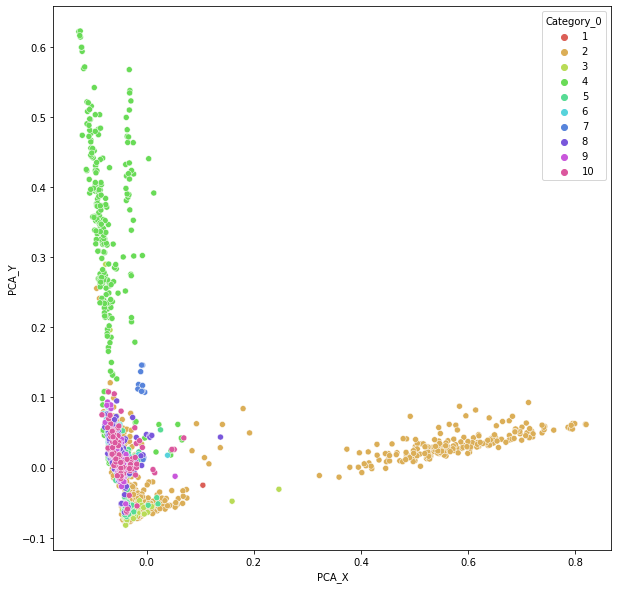

In [21]:
my_palette = sns.color_palette("hls", 10)
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='PCA_X', y='PCA_Y', hue='Category_0', palette=my_palette)

# T-SNE visualisation

Adapted from: https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization

Not so good above 4 dimensions

In [22]:
from sklearn.manifold import TSNE


X = tfidf_pipeline2.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1


pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=10)

tsne_data = model.fit_transform(X_r)

tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3218 samples in 0.005s...
[t-SNE] Computed neighbors for 3218 samples in 0.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3218
[t-SNE] Computed conditional probabilities for sample 2000 / 3218
[t-SNE] Computed conditional probabilities for sample 3000 / 3218
[t-SNE] Computed conditional probabilities for sample 3218 / 3218
[t-SNE] Mean sigma: 0.006904
[t-SNE] Computed conditional probabilities in 0.420s
[t-SNE] Iteration 50: error = 71.4280853, gradient norm = 0.0732360 (50 iterations in 1.387s)
[t-SNE] Iteration 100: error = 64.4928055, gradient norm = 0.0092675 (50 iterations in 0.878s)
[t-SNE] Iteration 150: error = 63.7314224, gradient norm = 0.0093434 (50 iterations in 0.860s)
[t-SNE] Iteration 200: error = 63.4136925, gradient norm = 0.0069203 (50 iterations in 0.847s)
[t-SNE] Iteration 250: error = 63.2381363, gradient norm = 0.0043556 (50 iterations in 1.174s)
[t-SNE] KL divergence after 250 iterat

In [23]:
df2 = CPA_L6.copy()
df2['dim1'] = tsne_data[:,0]
df2['dim2'] = tsne_data[:,1]
df2.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-21.439011,3.937685
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-22.643147,4.161631
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-20.220507,3.537269
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-18.420662,2.703956
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-15.815641,1.159902


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

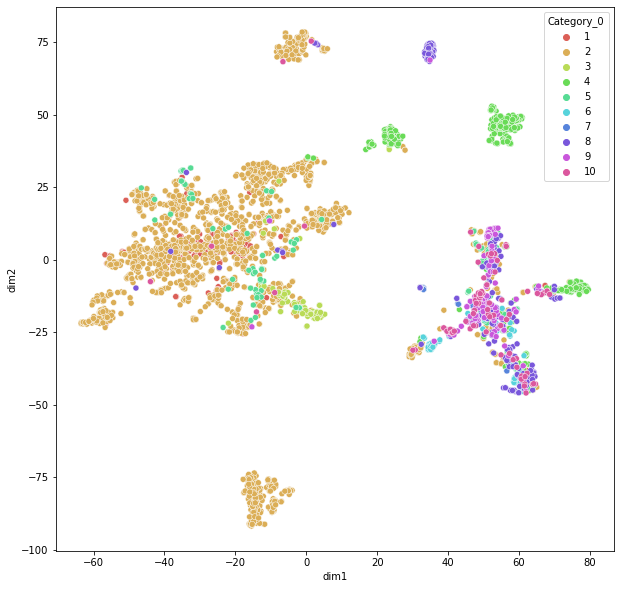

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df2,x='dim1', y='dim2', hue='Category_0',  palette=my_palette)

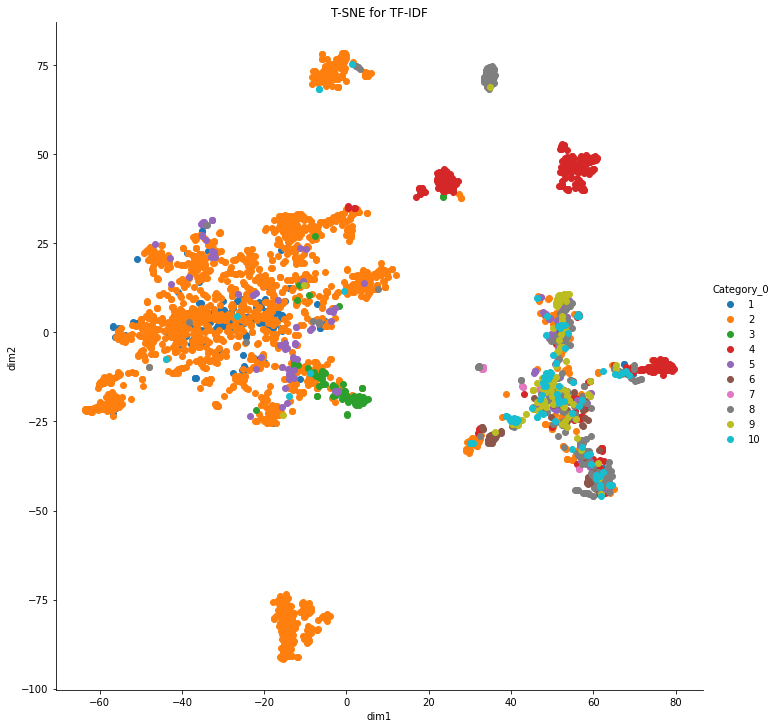

In [25]:
#sns.FacetGrid(tsne_df, hue="category", size=6, legend=None).map(plt.scatter, 'dim1', 'dim2').add_legend()
sns.FacetGrid(df2, hue="Category_0", height=10).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("T-SNE for TF-IDF");

In [26]:
import sklearn.metrics.pairwise

In [27]:
distance_matrix = sklearn.metrics.pairwise.cosine_distances(X)

<Figure size 432x288 with 0 Axes>

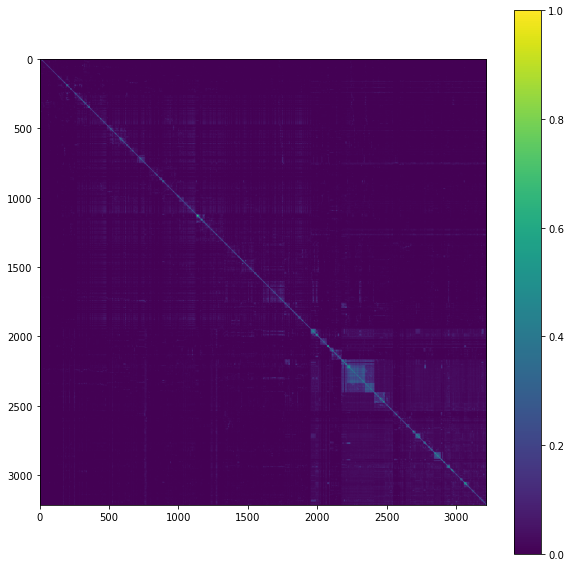

In [28]:
plt.set_cmap("viridis")
plt.figure(figsize=(10, 10))
plt.imshow(1-distance_matrix)
plt.colorbar();

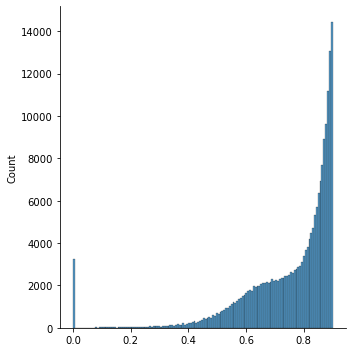

In [29]:
test = distance_matrix.flatten()
sns.displot(test[test<0.9])

<Figure size 720x720 with 0 Axes>

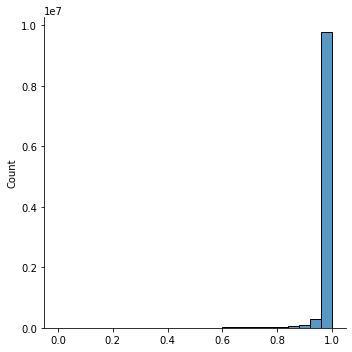

In [30]:
plt.figure(figsize=(10, 10))
sns.displot(distance_matrix.flatten())

## Discussion points:
* Curse of dimensionality
* Uni-modal pairwise distance distribution
* Dimensionality reduction
* Clustering e.g. HDBSCAN

# Classification

In [31]:
df2.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-21.439011,3.937685
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-22.643147,4.161631
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-20.220507,3.537269
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-18.420662,2.703956
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-15.815641,1.159902


In [32]:
df2['Category_3'] = df2.Category_0==2
df2

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2,Category_3
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-21.439011,3.937685,False
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-22.643147,4.161631,False
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-20.220507,3.537269,False
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-18.420662,2.703956,False
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-15.815641,1.159902,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5505,1214297,6,97.00.14,97.00.1,Services of households as employers of domesti...,Services households employers domestic personn...,97,T,10,41.775093,-24.612328,False
5506,1214298,6,97.00.19,97.00.1,Other services of households as employers of d...,Other services households employers domestic p...,97,T,10,51.780045,-19.671165,False
5511,1214303,6,98.10.10,98.10.1,Undifferentiated goods produced by private hou...,Undifferentiated goods produced private househ...,98,T,10,-43.975487,-7.534865,False
5515,1214307,6,98.20.10,98.20.1,Undifferentiated services produced by private ...,Undifferentiated services produced private hou...,98,T,10,47.148628,-18.566984,False


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

#train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
train_set, test_set = train_test_split(df2, test_size=0.2, random_state=42)
train_set.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2,Category_3
42,1208834,6,01.11.96,01.11.9,Castor oil seeds,Castor oil seeds,01,A,1,-34.506821,0.758167,False
4521,1213313,6,64.19.22,64.19.2,Consumer credit granting services by monetary ...,Consumer credit granting services monetary ins...,64,K,6,59.219814,-41.665630,False
34,1208826,6,01.11.81,01.11.8,Soya beans,Soya beans,01,A,1,-23.697916,4.422275,False
2680,1211472,6,28.24.99,28.24.9,Sub-contracted operations as part of manufactu...,Sub-contracted operations part manufacturing p...,28,C,2,-14.844070,-79.066025,True
1707,1210499,6,23.12.11,23.12.1,"Glass in sheets, bent, edge-worked, engraved, ...",Glass sheets bent edge-worked engraved drilled...,23,C,2,-42.174026,0.984662,True


In [34]:
X_train = train_set[['dim1','dim2']]
y_train_BE = train_set.Category_3
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_BE, cv=3,  method="predict_proba")


In [39]:
y_scores = cross_val_predict(forest_clf, X_train, y_train_BE, cv=3,
                             method='predict_proba')

In [40]:
y_scores

array([[0.21, 0.79],
       [0.92, 0.08],
       [0.12, 0.88],
       ...,
       [0.07, 0.93],
       [0.  , 1.  ],
       [0.94, 0.06]])

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_BE, y_scores[:,1])

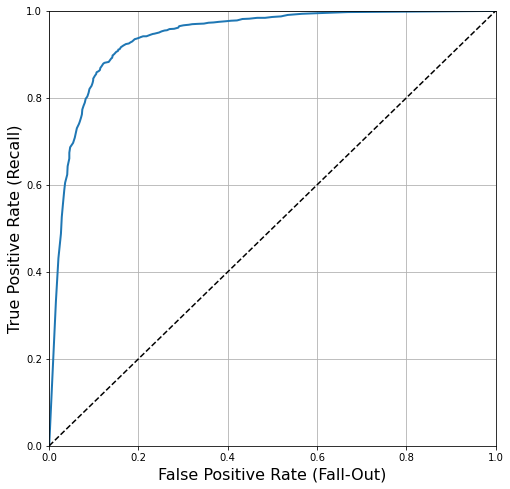

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 8))                         # Not shown
plot_roc_curve(fpr, tpr)

#save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_BE, y_scores[:,1])

0.9392807474402411

In [54]:
df2.Category_3.sum()

1874

In [51]:
len(df2)

3218

## UMAP example

In [ ]:
# u-map
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [ ]:

standard_embedding = umap.UMAP(random_state=42).fit_transform(df2.dim1, df2.dim2)